In [6]:
!pip install gql requests

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [7]:
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)


client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

In [8]:
# Generate the GraphQL query: find all works from PANGAEA Repository using keyword: "Field temperatures"
query_params = {
    "repository" : "pangaea.repository",
    "keyword" : "Field temperatures"
}

query = gql("""query getWorksByRepositoryAndKeyword($repository: ID!, $keyword: String!)
{
  repository(id: $repository) {
    id
    name
    works(query: $keyword) {
      totalCount
      years {
        title
        count
      }
      nodes {
        id
        type
        publicationYear
        bibtex
        titles {
          title
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

In [10]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

In [21]:
# Get the total number of datasets matching the query
works = data['repository']['works']
print("The number of works for repository %s:\n%s" % (query_params['repository'], str(works['totalCount'])))

The number of works for repository pangaea.repository:
117


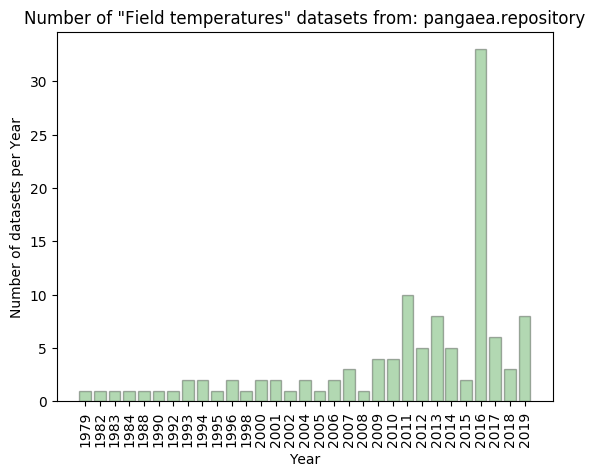

In [12]:
# Plot the total number of datasets to date, by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

plt.rcdefaults()

years = [s['title'] for s in works['years']]
num_outputs = [s['count'] for s in works['years']]

fig, ax = plt.subplots()
x_pos = np.arange(len(years))
ax.bar(x_pos, num_outputs, align='center', color='green', edgecolor='black', linewidth=1, alpha=0.3)
ax.set_xticks(x_pos)
ax.set_xticklabels(years, rotation='vertical')
ax.invert_xaxis()  # labels read top-to-bottom
ax.set_ylabel('Number of datasets per Year')
ax.set_xlabel('Year')
ax.set_title('Number of "%s" datasets from: %s' % (query_params["keyword"], query_params["repository"]))
plt.show()


In [46]:
from IPython.core.display import display, HTML

# Get details for each output
outputs = [['ID','Type','Publication Year','Titles','Number of Citations', 'Number of Views', 'Number of Downloads']]
for r in works['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    titles = '; '.join([s['title'] for s in r['titles']])
    output = [id, r['type'], str(r['publicationYear']), titles, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
    outputs += [output]
    
# Display outputs as html table 
html_table = '<html><table><caption><b>"%s" works from %s</b></caption>' % (query_params["keyword"], query_params["repository"])  
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Type,Publication Year,Titles,Number of Citations,Number of Views,Number of Downloads
10.1594/pangaea.858104,Dataset,2016,"Field temperatures along Mt. Kilimanjaro, Farm Kirua",0,0,0
10.1594/pangaea.858111,Dataset,2016,"Field temperatures along Mt. Kilimanjaro, Farm Moto",0,0,0
10.1594/pangaea.858115,Dataset,2016,"Field temperatures along Taita Hills, Farm Kighala",0,0,0
10.1594/pangaea.858110,Dataset,2016,"Field temperatures along Mt. Kilimanjaro, Farm Masila",0,0,0
10.1594/pangaea.858127,Dataset,2016,"Field temperatures along Taita Hills, Farm Singila",0,0,0
10.1594/pangaea.858103,Dataset,2016,"Field temperatures along Mt. Kilimanjaro, Farm Kanango",0,0,0
10.1594/pangaea.858122,Dataset,2016,"Field temperatures along Taita Hills, Farm Mwatungu",0,0,0
10.1594/pangaea.858112,Dataset,2016,"Field temperatures along Mt. Kilimanjaro, Farm Nduoni",0,0,0
10.1594/pangaea.858114,Dataset,2016,"Field temperatures along Taita Hills, Farm Dembwa",0,0,0
10.1594/pangaea.858109,Dataset,2016,"Field temperatures along Mt. Kilimanjaro, Farm Marua_B",0,0,0


In [36]:
from IPython.core.display import display, HTML

# Get bibtex entry for each output
outputs = [['ID','BibTeX']]
for r in works['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    bibtex = r['bibtex']
    output = [id, bibtex]
    outputs += [output]
    
# Display works' bibtex entries as html table 
html_table = '<html><table><caption><b>BibTeX entries for "%s" works from %s</caption></b>' % (query_params["keyword"], query_params["repository"])  
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,BibTeX
10.1594/pangaea.858104,"@misc{https://doi.org/10.1594/pangaea.858104, doi = {10.1594/PANGAEA.858104}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858104}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Kirua}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858111,"@misc{https://doi.org/10.1594/pangaea.858111, doi = {10.1594/PANGAEA.858111}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858111}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Moto}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858115,"@misc{https://doi.org/10.1594/pangaea.858115, doi = {10.1594/PANGAEA.858115}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858115}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Taita Hills, Farm Kighala}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858110,"@misc{https://doi.org/10.1594/pangaea.858110, doi = {10.1594/PANGAEA.858110}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858110}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Masila}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858127,"@misc{https://doi.org/10.1594/pangaea.858127, doi = {10.1594/PANGAEA.858127}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858127}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Taita Hills, Farm Singila}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858103,"@misc{https://doi.org/10.1594/pangaea.858103, doi = {10.1594/PANGAEA.858103}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858103}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Kanango}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858122,"@misc{https://doi.org/10.1594/pangaea.858122, doi = {10.1594/PANGAEA.858122}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858122}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Taita Hills, Farm Mwatungu}, publisher = {PANGAEA - Data Pub

In [41]:
# Generate the GraphQL query: Get citations for a specific work from the repository
citations_query_params = {
    "id" : "https://doi.org/10.1594/pangaea.51988",
    "maxCitations" : 75
}

citation_query = gql("""query getCitationsByWorkId($id: ID!, $maxCitations: Int!)
{
  work(id: $id) {
    id
    titles {
      title
    }
    type
    publicationYear
    citations(first: $maxCitations) {
      totalCount
      nodes {
        id
        type
        publicationYear
        repository {
          id
          name
        }
        titles {
          title
        }
        bibtex
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

In [43]:
import json
citations = client.execute(citation_query, variable_values=json.dumps(citations_query_params))

In [48]:
# Get the total number of citations matching the query
citations_data = citations['work']['citations']
print("The number of citations for work %s:\n%s" % (citations_query_params["id"], str(citations_data['totalCount'])))

The number of citations for work https://doi.org/10.1594/pangaea.51988:
29768585


In [50]:
from IPython.core.display import display, HTML

# Get details for each citation
outputs = [['ID','Type','Publication Year','Titles','Number of Citations', 'Number of Views', 'Number of Downloads']]
for r in citations_data['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    titles = '; '.join([s['title'] for s in r['titles']])
    output = [id, r['type'], str(r['publicationYear']), titles, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
    outputs += [output]
    
# Display outputs as html table 
html_table = '<html><table><caption><b>Citations of %s from %s</b></caption>' % (id, query_params["repository"])  
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Type,Publication Year,Titles,Number of Citations,Number of Views,Number of Downloads
10.15468/dl.we2dps,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.eq5bv2,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.3hfznv,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.iajmrl,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.orj95u,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.xxsgel,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.y0v1dk,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.l6lk2m,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.lflyza,Dataset,2020,Occurrence Download,0,0,0
10.15468/dl.cwdcvt,Dataset,2020,Occurrence Download,0,0,0


In [52]:
from IPython.core.display import display, HTML

# Get bibtex entry for each output
outputs = [['ID','BibTeX']]
for r in works['nodes']:
    id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    bibtex = r['bibtex']
    output = [id, bibtex]
    outputs += [output]
    
# Display citations' bibtex entries as html table 
html_table = '<html><table><caption><b>BibTeX entries for citations of %s from %s</caption></b>' % (id, query_params["repository"])  
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,BibTeX
10.1594/pangaea.858104,"@misc{https://doi.org/10.1594/pangaea.858104, doi = {10.1594/PANGAEA.858104}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858104}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Kirua}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858111,"@misc{https://doi.org/10.1594/pangaea.858111, doi = {10.1594/PANGAEA.858111}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858111}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Moto}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858115,"@misc{https://doi.org/10.1594/pangaea.858115, doi = {10.1594/PANGAEA.858115}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858115}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Taita Hills, Farm Kighala}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858110,"@misc{https://doi.org/10.1594/pangaea.858110, doi = {10.1594/PANGAEA.858110}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858110}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Masila}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858127,"@misc{https://doi.org/10.1594/pangaea.858127, doi = {10.1594/PANGAEA.858127}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858127}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Taita Hills, Farm Singila}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858103,"@misc{https://doi.org/10.1594/pangaea.858103, doi = {10.1594/PANGAEA.858103}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858103}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Mt. Kilimanjaro, Farm Kanango}, publisher = {PANGAEA - Data Publisher for Earth & Environmental Science}, year = {2016} }"
10.1594/pangaea.858122,"@misc{https://doi.org/10.1594/pangaea.858122, doi = {10.1594/PANGAEA.858122}, url = {https://doi.pangaea.de/10.1594/PANGAEA.858122}, author = {Ngowi, Benignus V and Tonnang, Henri E Z and Mwangi, Evans M and Johansson, Tino and Ambale, Janet and Ndegwa, Peter N and Subramanian, Sevgan}, keywords = {Day of the year, DATE/TIME, Temperature, air, minimum, Temperature, air, maximum}, language = {en}, title = {Field temperatures along Taita Hills, Farm Mwatungu}, publisher = {PANGAEA - Data Pub